# 60nm AuNP Deposition Process: Simulation vs. Experiment

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**!!!Run next cell twice if get warnings at the first time!!!**

In [3]:
#!!!Run this cell twice if get warnings about simparser
import numpy as np
import pandas as pd
from pame.simparser import LayerSimParser #Interface for handling simulation results

## Experiment Conditions

(1) PAME simulation: 

NP core material: **main_Au_Lemarchand-11.7nm**, 60nm

**Lemarchand60nm_15steps.mpicklee**: Vfrac: **0-0.133, 15 steps**, corresponding disk coverage: **0 - 25.40%**;

**Lemarchand60nm.mpickle**: Vfrac: **0-0.09, 30 steps**, corresponding disk coverage: **0 - 17.18%**;

sellmeier coefficients: **A1=6.0, A2=3.2, A3=0.89, B1=1.3, B2=0.0, B3=50.0, 2nm**
(**Same silanes settings with 22nm simulation**)

(2) Experiment Data: 09_13_2015/Fiber1/NPSAM (1450-4000units).

Unknown surface coverage. But we've processed the SEM image of a similar fiber, 08_17_2015/Fiber3. Its surface coverage = 0.093989
https://github.com/EvelynLiu77/Lab_share/blob/master/60nmAuNP.ipynb

## Define Datafiles Importing Functions

When dealing with UV-VIS spectra, the conversion between different measures, e.g. from nm to m and from reflectance to absorbance, is necessary. Therefore, in Scikit Spectra, the python library we developed, we defined units and conversions in the datafiles importing workflow. Many other customized features were also built in the ScikitSpectra, which are very convinent for spectrum processing.

However, the data structure of Scikit Spectra was based on Pandas DataFrame. When Pandas changed some deep implementations, those customized features need to be altered accordingly.

Instead of changing data structure of the library, I decided to use Pandas DataFrame directly to import our data, so we won't have any problem with compatibility. We have to mannually convert measurements&units when needed.

In [4]:
from pandas import DataFrame, read_csv, concat
import os
import os.path as op

def get_files_in_dir(directory, sort=True):
    ''' Given a directory, returns just the files; ignores directories '''

    # If path entered with or without trailing '/', account for it
    directory = directory.rstrip('/')    
    files = [op.join(directory, item) for item in os.listdir(directory) if 
             op.isfile(op.join(directory, item))]

    if sort:
        files.sort()
    return files

def get_shortname(filepath, cut_extension=False):
    ''' simply get the filename of fullpath.  Cut extension will remove file extension'''
    shortname=os.path.basename(filepath) 
    if cut_extension:
        shortname=os.path.splitext(shortname)[0]  #Cut file extension
    return shortname

def df_from_directory(directory, csvargs, sortnames=False, concat_axis=1, shortname=True, cut_extension=False):

    filelist=get_files_in_dir(directory)

    if shortname:
        fget=lambda x:get_shortname(x, cut_extension=cut_extension)
    else:
        fget=lambda x: x
    
    ### Either full names or short names of filelist    
    working_names=[fget(afile) for afile in filelist]       

    ### This parameter can't be passed in, so if user does so, pull it out.
    try:
        csvargs.pop('names')
    except KeyError:
        pass
    else:
        raise Warning('Please do not enter a names keyword for csvargs, it gets inferred from the filenames in\
        the directory.')

    dflist=[read_csv(afile, names=[fget(afile)], **csvargs) for afile in filelist]
    
    ### THIS IS BUSTED, PUTTING NANS EVERYWHERE EXCEPT ONE FILE, but dflist itself ws nice.
    dataframe=concat(dflist, axis=1)
                        
    ### concat tries to sort these, so this will preserve the sort order
    if sortnames:
        dataframe=dataframe.reindex(columns=sorted(working_names))

    return dataframe

## Import PAME Simulation

/Users/zhaodongmei/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


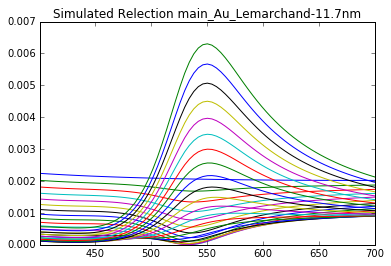

In [5]:
s1=LayerSimParser.load_pickle('./mpickle_files/Lemarchand60nm.mpickle')
df1=s1.primary_panel()['R_avg'].ix[400:,0:30]
spec1 = pd.DataFrame(df1.values, index=df1.index, columns=s1.inputs['selected_material.TotalMix.Vfrac'][0:30])
spec1.reference=0
spec1.plot(title='Simulated Relection main_Au_Lemarchand-11.7nm',legend=False)

In [6]:
#s1.inputs['selected_material.TotalMix.Vfrac']

## Import Experiment Results

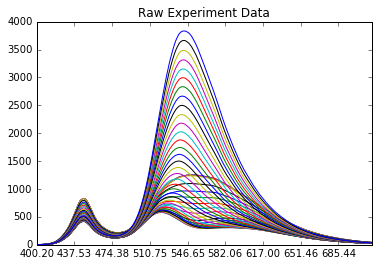

In [7]:
directory = './NPSAM_60nm'
directory = directory.rstrip('/')    
filelist = [op.join(directory, item) for item in os.listdir(directory) if 
             op.isfile(op.join(directory, item))][1:]
df = pd.concat([pd.read_csv(item, names=[item[-8:-4]],sep='\t',header=16) for item in filelist], axis=1).ix[161:1050]
spec2 = (df.T-df.T.iloc[0]).T.ix[:,1:]
spec2.plot(title='Raw Experiment Data',legend=False)

## Convert Raw Data to Reflection & Absorbance

In [8]:
ref1=(spec1.T/spec1.T.iloc[0]).T #Reflection
ref2=(spec2.T/spec2.T.iloc[0]).T #Reflection

ref1_real = pd.DataFrame(ref1.values.real).astype('float')
abs1= -np.log10(ref1_real) #Absorbance
ref2_real = pd.DataFrame(ref2.values.real).astype('float')
abs2= -np.log10(ref2_real) #Absorbance

## Compare PAME Simuation with Experiment Results

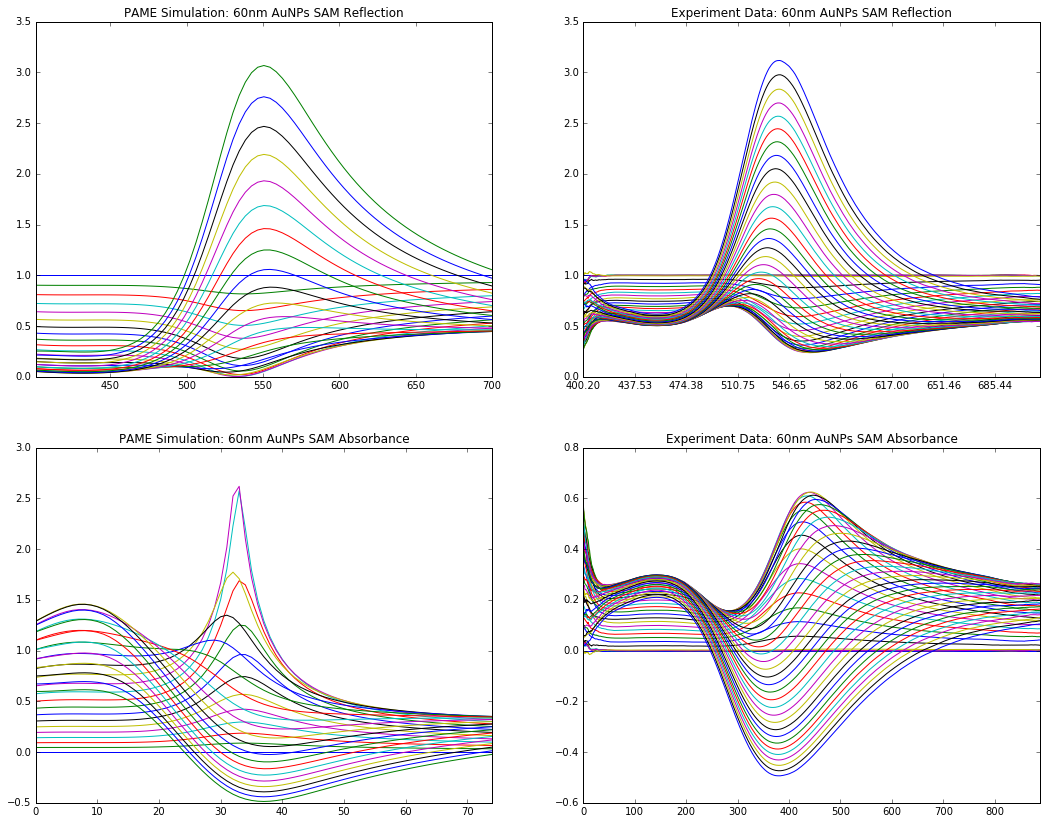

In [9]:
fig, ((ax3, ax4),(ax5, ax6)) = plt.subplots(2, 2,figsize=(18,14))

ref1.plot(ax=ax3,title='PAME Simulation: 60nm AuNPs SAM Reflection',legend=False)
ref2.plot(ax=ax4,title='Experiment Data: 60nm AuNPs SAM Reflection',legend=False)
abs1.plot(ax=ax5,title='PAME Simulation: 60nm AuNPs SAM Absorbance',legend=False)
abs2.plot(ax=ax6,title='Experiment Data: 60nm AuNPs SAM Absorbance',legend=False)

The above figure shows that the simulated spectra shares very similar trend with the experimental result of 60nm AuNPs. This suggests that, both for 22nm and 60nm AuNPs, the Sellmeier model work well for simulating the Silanes layer. We will tune the Sellmeier parameters to fit them better.